In [7]:
import pandas as pd
import operator
import numpy as np
import scipy.stats as sps

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import matplotlib as mpl
mpl.use('TkAgg')

import emcee
import pymc3 as pm

from astropy.table import Table
import astropy.io as asio
from astropy.io import fits
import corner

import io
from google.colab import files

import matplotlib.gridspec as gridspec

%matplotlib inline

def nanmask(array):
    mask = (np.isnan(array) == False)
    newarray = array[mask]
    return newarray, mask

def seanscat(x,y):
    xlab = input("What would you like the x label to be?")
    ylab = input("What would you like the y label to be?")
    pointsize = input("What would you like the size of the scatter points to be?")
    plt.scatter(x,y,s=int(pointsize))
    plt.xlim(0.9*min(x),1.1*max(x))
    plt.ylim(0.9*min(y),1.1*max(y))
    plt.grid()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(xlab+" vs. "+ylab)
    plt.show()
    
def reducer(df,keycol,key=np.inf):
    delindex=[]
    for i in range(len(keycol)):
        if keycol[i]!=key:
            delindex.append(i)
    return df.drop(delindex)

def reducer2(df,keycol,key=np.inf):
    delindex=[]
    for i in range(len(keycol)): # if key = keycol value
        if keycol[i]==key:
            delindex.append(i)
    return df.drop(delindex)

def reducer3(df,keycol):
    delindex=[]
    for i in range(len(keycol)):
        if np.isnan(keycol[i])==True:
            delindex.append(i)
    return df.drop(delindex)

def residMCMC(sig_y_obs,m,sig_m,x,sig_x,sig_b):
    sig_mx = np.abs(m*x)*np.sqrt((sig_m/m)**2+(sig_x/x)**2)
    sig_mxpb = np.sqrt(sig_mx**2+sig_b**2)
    return np.sqrt((sig_y_obs)**2+(sig_mxpb)**2)

def linfit(m,x,b):
    return m*x+b

def percSplit(splitArr,lowlim=15.87,uplim=84.13): # defaults to 1sigma levels
    upperval = np.percentile(splitArr,uplim)
    lowerval = np.percentile(splitArr,lowlim)
    upperlist,lowerlist = [],[]
    for i in range(len(splitArr)):
        if np.asarray(splitArr)[i]>upperval:
            upperlist.append(i)
        elif np.asarray(splitArr)[i]<lowerval:
            lowerlist.append(i)
    return upperval, lowerval, upperlist,lowerlist

from matplotlib.pyplot import figure
BDecLabel = "$\log$(H\u03B1/H\u03B2)"
LCO10Label = "$\log(L_{CO_{1-0}})$ [K km s$^{-1}$ pc$^2$]"
LCO21Label = "$\log$($L_{CO_{2-1}}$)"
MDustLabel = "$\log$(M$_{Dust})$[M$_\odot$]"
MH2Label = "$\log$($M_{H_2})$[M$_\odot$]"
StarMassLabel = "$\log$(M$_{Star}$) [M$_\odot$]"
SFRLabel = "$\log$(SFR) [$M_\odot$ yr$^{-1}$]"
GasFracLabel = "$\log (f_{H_2})$"
N2HALabel = "$\log$(N$_2$/H\alpha)"

m_MDust = 2.59 # dust
b_MDust = 6.15
m_sd_MDust = .3
b_sd_MDust = .2
f_MDust = 0.28

m_LCO10 = 5.89 # LCO 1-0
b_LCO10 = 4.59
m_sd_LCO10 = .53
b_sd_LCO10 = .33
f_LCO10 = 0.44

m_MH2 = 4.27 # MH2
b_MH2 = 6.29
m_sd_MH2 = .42
b_sd_MH2 = .26
f_MH2 = 0.31

lilPsize = 5
bigPsize = 10

def getMean(x,y,z):
    
    x=np.asarray(x)
    y=np.asarray(y)
    z=np.asarray(z)
    
    minx = 9 # set all these manually
    maxx = 11.5
    miny = -2.5 # should b min(y)
    maxy = 1.75
    points_x = np.linspace(minx,maxx,num=grids)
    points_y = np.linspace(miny,maxx,num=grids)
    gridX,gridY = np.meshgrid(points_x,points_y)
    gridZ = np.zeros([len(gridX),len(gridX)])
    del_x = (maxx-minx)/(2*grids)
    del_y = (maxy-miny)/(2*grids)
    
    for i in range(len(points_x)): # double looping gridX
        for j in range(len(points_y)):
            sumlist=0
            countlist=0
            for g in range(len(x)):
                if x[g]>=(points_x[i]-del_x) and x[g]<=(points_x[i]+del_x) and y[g]>=(points_y[j]-del_y) and y[g]<=(points_y[j]+del_y):
                    sumlist+=z[i]
                    countlist+=1
            if sumlist!=0:
                gridZ[j][i] = sumlist/countlist
    return gridX,gridY,gridZ

In [175]:
matchdf = Table.read("CAS-IDs.fits", format='fits').to_pandas()
mpaMaster=pd.read_csv("MPAMaster.csv")
# print(len(mpaMaster),len(matchdf))

del mpaMaster["Unnamed: 0"]

mpaMaster["SPECOBJID"]=matchdf["SPECOBJID"]
mpaMaster["objid"]=matchdf["OBJID"]

In [176]:
mpaMaster.columns.values

# matchdf.columns.values

array(['Z', 'Z err', 'H alpha flux', 'H alpha flux error', 'H beta flux',
       'H beta flux error', 'BDec', 'BDec Err', 'objid', 'expAB_r', 'RA',
       'DEC', 'StarMass', 'StarMass P16', 'StarMass P84', 'SFR',
       'SFR P16', 'SFR P84', 'SFR err', 'SFR FLAG', 'SFR ENTROPY',
       'GALAXY CLASS', '12+LOG OH', '12+LOG OH P16', '12+LOG OH P84',
       '12+LOG OH err', 'EB-V', 'SPECOBJID'], dtype=object)

In [177]:
delindex =[]

for i in range(len(mpaMaster)):
    if mpaMaster["Z"][i]>0.06:
        delindex.append(i)
    elif mpaMaster["Z"][i]<0:
        delindex.append(i)
    elif (mpaMaster["H alpha flux"][i]/mpaMaster["H alpha flux error"][i])<5:
        delindex.append(i)
    elif (mpaMaster["H beta flux"][i]/mpaMaster["H beta flux error"][i])<5:
        delindex.append(i)
    elif mpaMaster["StarMass"][i]<9:
        delindex.append(i)
    elif mpaMaster["GALAXY CLASS"][i]!=1:
        delindex.append(i)
#     elif mpaMaster["SPECOBJID"][i]<100:
#         delindex.append(i)

mpaMaster = mpaMaster.drop(delindex)

In [178]:
mpaMaster["LogBalmerDec"] = np.log10(mpaMaster["H alpha flux"]/mpaMaster["H beta flux"])
mpaMaster["LogBalmerDec Err"] = (np.sqrt((mpaMaster["H alpha flux error"])**2+(mpaMaster["H beta flux error"])**2)*mpaMaster["H beta flux"])/(mpaMaster["H alpha flux"]*np.log(10))

mpaMaster["MH2_MCMC"] = m_MH2*mpaMaster["LogBalmerDec"]+b_MH2
mpaMaster["LCO10_MCMC"] = m_LCO10*mpaMaster["LogBalmerDec"]+b_LCO10

mpaMaster["MDust_MCMC"] = m_MDust*mpaMaster["LogBalmerDec"]+b_MDust

mpaMaster["GasFrac_MCMC"] = np.log10((10**mpaMaster["MH2_MCMC"])/(10**mpaMaster["StarMass"]))

In [179]:
mpaMaster.columns.values

array(['Z', 'Z err', 'H alpha flux', 'H alpha flux error', 'H beta flux',
       'H beta flux error', 'BDec', 'BDec Err', 'objid', 'expAB_r', 'RA',
       'DEC', 'StarMass', 'StarMass P16', 'StarMass P84', 'SFR',
       'SFR P16', 'SFR P84', 'SFR err', 'SFR FLAG', 'SFR ENTROPY',
       'GALAXY CLASS', '12+LOG OH', '12+LOG OH P16', '12+LOG OH P84',
       '12+LOG OH err', 'EB-V', 'SPECOBJID', 'LogBalmerDec',
       'LogBalmerDec Err', 'MH2_MCMC', 'LCO10_MCMC', 'MDust_MCMC',
       'GasFrac_MCMC'], dtype=object)

In [180]:
mpaMaster.to_csv("Sanitycheck.csv",index=False)

mpaMaster=mpaMaster.reset_index()

I went to CASJOBS, retrieved expAB_r's for sources with matching objID's from the "Sanitycheck.csv" - DIDN'T WORK INITIALLY

Now with the SDSS helpdesk trying to fix problem

Fixed! appropriate expAB_r measurement is in objIDs_Seannieboyy.csv file

In [181]:
objIDsdf = pd.read_csv("objIDs_Seannieboyy.csv")
objIDsdf["Incl"]=(180/np.pi)*np.arccos(objIDsdf["expAB_r"])

In [196]:
# print(objIDsdf["dr7objid"])

# objIDsdf.columns.values

# print(mpaMaster["objid"])

# mpaMaster["Incl"] = -99.0

tmpList=np.zeros(len(mpaMaster))
tmpList = 99

# for i in range(len(mpaMaster)):
#     for j in range(len(objIDsdf)):
#         if mpaMaster["objid"][i]==objIDsdf["dr7objid"][j]:
#             mpaMaster["Incl"][i]=objIDsdf["Incl"][j]
#             print("doot"+str(i))
#             break

In [191]:
delindex = []

for i in range(len(mpaMaster)):
    if mpaMaster["Incl"][i]<0:
        delindex.append(i)
mpaMaster=mpaMaster.drop(delindex)

In [195]:
mpaMaster.to_csv("Sanitycheck2.csv",index=False)

# mpaMaster=mpaMaster.reset_index()

In [8]:
mpaMaster = pd.read_csv("Sanitycheck2.csv")

In [4]:
print(mpaMaster["Incl"])

0        62
1        62
2        78
3        58
4        26
5        70
6        77
7        60
8        77
9        47
10       65
11       54
12       67
13       50
14       67
15       73
16       67
17       45
18       46
19       45
20       58
21       59
22       65
23       51
24       55
25       62
26       60
27       54
28       78
29       62
         ..
54435    30
54436    43
54437    78
54438    19
54439    54
54440    59
54441    52
54442    52
54443    60
54444    69
54445    69
54446    55
54447    46
54448    67
54449    37
54450    69
54451    78
54452    15
54453    59
54454    54
54455    67
54456    57
54457    77
54458    64
54459    47
54460    18
54461    62
54462    42
54463    47
54464    55
Name: Incl, Length: 54465, dtype: int64


In [9]:
upperinc, lowerinc, upperindex_inc,lowerindex_inc = percSplit(mpaMaster["Incl"])

In [10]:
print(upperinc,lowerinc)

73.0 36.0


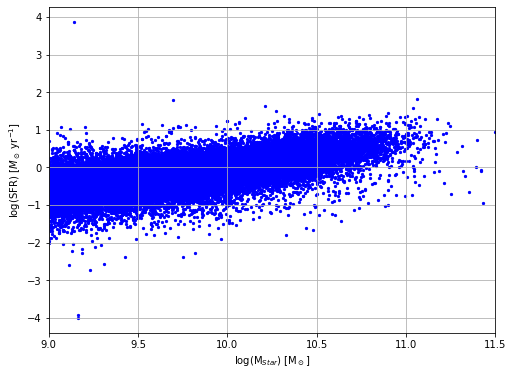

In [6]:
fig=plt.figure(figsize=[8,6])

plt.scatter(mpaMaster["StarMass"],mpaMaster["SFR"],c="blue",s=lilPsize)

plt.xlim(9,11.5)
# plt.colorbar()
plt.ylabel(SFRLabel)
plt.xlabel(StarMassLabel)
plt.grid()
# plt.text(12,-1,MH2Label,rotation=-90)

plt.savefig("SDSS_fullspread.png",dpi=300)

plt.show()

$M_{H_2}$

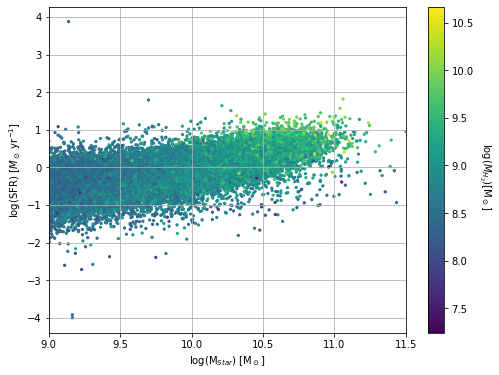

In [260]:
fig=plt.figure(figsize=[8,6])

plt.scatter(mpaMaster["StarMass"],mpaMaster["SFR"],c=mpaMaster["MH2_MCMC"],s=lilPsize)

plt.xlim(9,11.5)
plt.colorbar()
plt.ylabel(SFRLabel)
plt.xlabel(StarMassLabel)
plt.grid()
plt.text(12,-1,MH2Label,rotation=-90)

plt.savefig("SDSS_MH2.png",dpi=300)

plt.show()

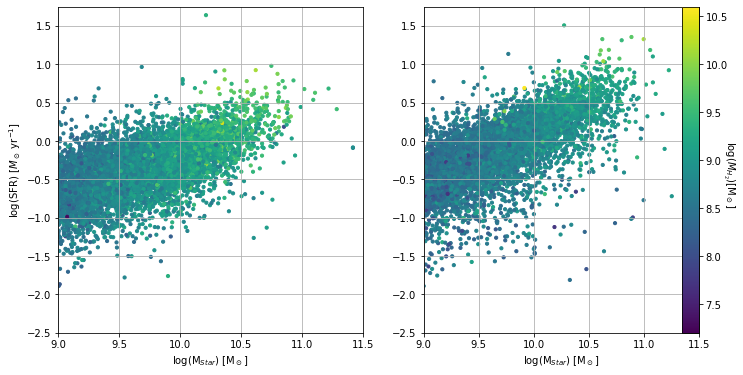

In [290]:
fig = plt.figure(1, figsize=[12,6])

gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))

plt.scatter(mpaMaster["StarMass"][upperindex_inc],mpaMaster["SFR"][upperindex_inc],c=mpaMaster["MH2_MCMC"][upperindex_inc],s=bigPsize)
plt.grid()
# plt.colorbar()
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
# plt.text(12.05,-.8,MH2Label,rotation=-90)
plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)
plt.clim(vmin=7.2,vmax=10.6)

plt.subplot2grid((1,2), (0,1))

plt.scatter(mpaMaster["StarMass"][lowerindex_inc],mpaMaster["SFR"][lowerindex_inc],c=mpaMaster["MH2_MCMC"][lowerindex_inc],s=bigPsize)
plt.grid(True)
# plt.yaxis.set_ticklabels([])
plt.colorbar(pad=-0.055)
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
plt.text(11.7,-.8,MH2Label,rotation=-90)
plt.xlabel(StarMassLabel)

# plt.ylabel(SFRLabel)

plt.clim(vmin=7.2,vmax=10.6)

plt.savefig("SDSS_MH2_InclSplit.png",dpi=300)

plt.show()

Dust

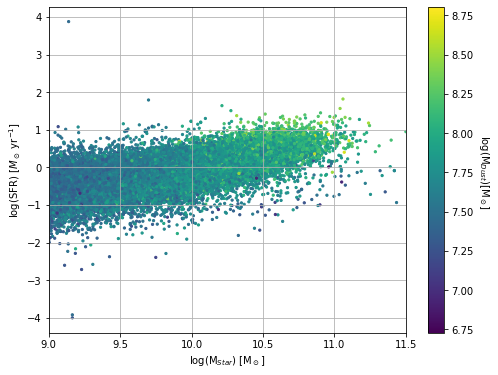

In [295]:
fig=plt.figure(figsize=[8,6])

plt.scatter(mpaMaster["StarMass"],mpaMaster["SFR"],c=mpaMaster["MDust_MCMC"],s=lilPsize)

plt.xlim(9,11.5)
plt.colorbar()
plt.ylabel(SFRLabel)
plt.xlabel(StarMassLabel)
plt.grid()
plt.text(12,-1,MDustLabel,rotation=-90)

plt.savefig("SDSS_Dust.png",dpi=300)

plt.show()

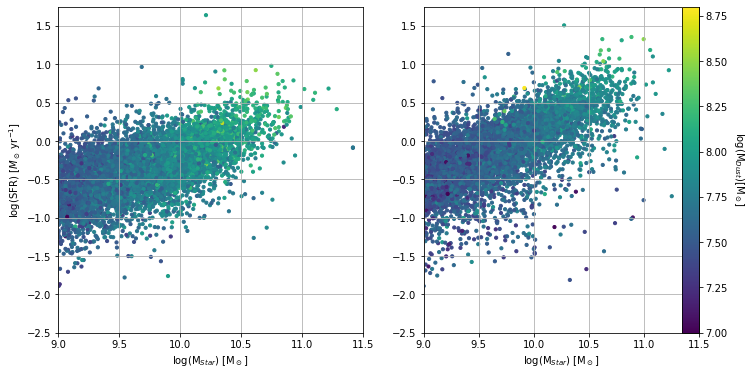

In [293]:
fig = plt.figure(1, figsize=[12,6])

gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))

plt.scatter(mpaMaster["StarMass"][upperindex_inc],mpaMaster["SFR"][upperindex_inc],c=mpaMaster["MDust_MCMC"][upperindex_inc],s=bigPsize)
plt.grid()
# plt.colorbar()
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
# plt.text(12.05,-.8,MDustLabel,rotation=-90)
plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)
plt.clim(vmin=7,vmax=8.8)

plt.subplot2grid((1,2), (0,1))

plt.scatter(mpaMaster["StarMass"][lowerindex_inc],mpaMaster["SFR"][lowerindex_inc],c=mpaMaster["MDust_MCMC"][lowerindex_inc],s=bigPsize)
plt.grid()
plt.colorbar(pad=-0.055)
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
plt.text(11.8,-.8,MDustLabel,rotation=-90)
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.clim(vmin=7,vmax=8.8)

plt.savefig("SDSS_Dust_InclSplit.png",dpi=300)

plt.show()

GasFraction

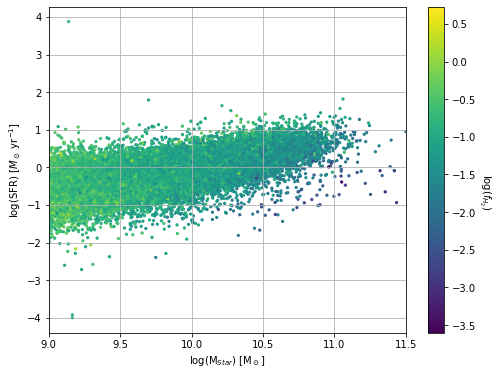

In [17]:
fig=plt.figure(figsize=[8,6])

plt.scatter(mpaMaster["StarMass"],mpaMaster["SFR"],c=mpaMaster["GasFrac_MCMC"],s=lilPsize)

plt.xlim(9,11.5)
plt.colorbar()
plt.ylabel(SFRLabel)
plt.xlabel(StarMassLabel)
plt.grid()
plt.text(12,-1,GasFracLabel,rotation=-90)

plt.savefig("SDSS_GasFrac.png",dpi=300)

plt.show()

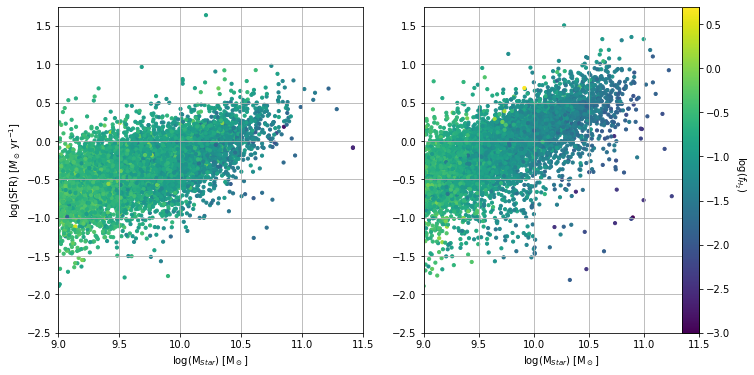

In [16]:
fig = plt.figure(1, figsize=[12,6])

gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))

plt.scatter(mpaMaster["StarMass"][upperindex_inc],mpaMaster["SFR"][upperindex_inc],c=mpaMaster["GasFrac_MCMC"][upperindex_inc],s=bigPsize)
plt.grid()
# plt.colorbar()
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
# plt.text(12.05,-.8,GasFracLabel,rotation=-90)
plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)
plt.clim(vmin=-3,vmax=.7)

plt.subplot2grid((1,2), (0,1))

plt.scatter(mpaMaster["StarMass"][lowerindex_inc],mpaMaster["SFR"][lowerindex_inc],c=mpaMaster["GasFrac_MCMC"][lowerindex_inc],s=bigPsize)
plt.grid()
plt.colorbar(pad=-0.055)
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
plt.text(11.8,-.6,GasFracLabel,rotation=-90)
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.clim(vmin=-3,vmax=.7)

plt.savefig("SDSS_GasFrac_InclSplit.png",dpi=300)

plt.show()

In [253]:
grids=100

# tmp = np.asarray(mpaMaster["StarMass"][upperindex_inc])

upperincx,upperincy,upperincz = getMean(mpaMaster["StarMass"][upperindex_inc],mpaMaster["SFR"][upperindex_inc],mpaMaster["GasFrac_MCMC"][upperindex_inc])
lowerincx,lowerincy,lowerincz = getMean(mpaMaster["StarMass"][lowerindex_inc],mpaMaster["SFR"][lowerindex_inc],mpaMaster["GasFrac_MCMC"][lowerindex_inc])


In [254]:
difgrid=upperincz-lowerincz

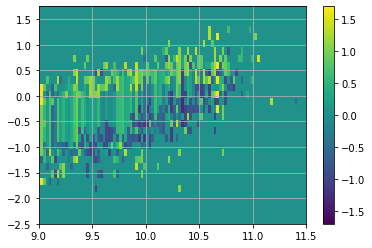

In [257]:
# print(difgrid)

plt.scatter(upperincx,upperincy,c=difgrid,s=50,marker="s")
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
plt.colorbar()
plt.clim(-1.7,1.7)
plt.grid()

plt.show()

In [296]:
print(len(mpaMaster))

54465
